# 🤖 Student Success Modeling Scaffold
This notebook will guide you through building both a classification and regression model using the cleaned dataset.

**Classification Goal**: Predict if a student will pass or fail.
**Regression Goal**: Predict the student’s final numeric score.

## 📥 Step 1: Load Blended Dataset

In [1]:
# TODO: Load the merged CSV file
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns

from xgboost import XGBRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.inspection import PartialDependenceDisplay
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, mean_squared_error, r2_score, confusion_matrix
import matplotlib.pyplot as plt

# df = pd.read_csv('student_success_blended_lowercase.csv')
df = pd.read_csv('updated_with_scores.csv')
# Optional: Check the column names and preview data
# df.head()

## 🧹 Step 2: Prepare Features and Targets

In [2]:
# TODO: Choose predictors and prepare targets for classification and regression

# Changing from string to int values
df_full = df.copy()

# Создаём бинарный таргет заранее
df_full["final_result_clean"] = df_full["final_result"].str.strip().str.lower()
df_full["target_pass"] = df_full["final_result_clean"].apply(lambda x: 1 if x == "pass" else 0)
df_full = df_full.drop(columns=["final_result","final_result_clean"])

# Cols which can cause leaking for Classification
remove_cols_clf = [
    "final_result",       # Classification target
    "target_pass",        # Classification target
    
]
# Cols which can cause leaking for Regression
remove_cols_reg = [
    "avg_assessment_score" # Regression target
]

# Categorical cols if we would like to use some of them
categorical_cols = [
    'gender',
    'region',
    'highest_education',
    'imd_band',
    'age_band',
    'disability',
    'module',
    'presentation'
]

# Numeric features
numeric_features = [
    'assessments_attempted',
    "avg_assessment_score",
    'total_clicks',
    'active_days',
    'studied_credits',
    'num_of_prev_attempts',
        # NEW — strongest predictors!
    'score_assignment_1',
    'score_quiz_2',
    'score_exam',
    'attempts_per_assessment'
]

combined = numeric_features + categorical_cols

# One-hot encoding for Categorical
df_encoded = pd.get_dummies(df_full, columns=categorical_cols, drop_first=True).astype(int)

# Classification
X_clf = df_full[numeric_features] # only numerical features
y_clf = df_full["target_pass"] 

# Features to test a contribution for LinearRegression
selected_features = [
    ## Behavioral
    'assessments_attempted',
    'active_days',

    ## Socio-economic
    'imd_band_30-40%', 'imd_band_40-50%', 'imd_band_50-60%',
    'imd_band_60-70%', 'imd_band_70-80%', 'imd_band_80-90%',
    'imd_band_90-100%',

    ## Education level
    'highest_education_Post Graduate Qualification',
    'highest_education_HE Qualification',
    'highest_education_Lower Than A Level',

    ## Disability
    'disability_Y',

    ## Module (course factor)
    'module_GGG', 'module_BBB', 'module_EEE', 'module_FFF',

    ## Presentation (semester factor)
    'presentation_2013J', 'presentation_2014J'
]

# Updated features to improve the R^2 - ( before new features )
updated_selected_features = [
    ## Behavioral
    'assessments_attempted',
    'active_days',

    ## Education level
    'highest_education_Post Graduate Qualification',
    'highest_education_HE Qualification',
    'highest_education_Lower Than A Level',

    ## Disability
    'disability_Y',

    ## Module (course factor)
    'module_GGG', 'module_BBB', 'module_EEE', 'module_FFF',

    ## Presentation (semester factor)
    'presentation_2013J', 'presentation_2014J'
]

# New features to improve the LR performance
reg_features = [

    # Behavioral
    'assessments_attempted',
    'active_days',
    'total_clicks',
    'studied_credits',

    # NEW — strongest predictors!
    'score_assignment_1',
    'score_quiz_2',
    'score_exam',
    'attempts_per_assessment'
]

#Regression
y_reg = df_full["avg_assessment_score"]
X_reg = df_encoded[reg_features]

X_reg.head(10)

,assessments_attempted,active_days,total_clicks,studied_credits,score_assignment_1,score_quiz_2,score_exam,attempts_per_assessment
0,5,40,934,240,71,61,80,0
1,5,80,1435,60,63,61,72,0
2,5,123,2158,60,75,71,87,0
3,5,70,1034,60,52,52,63,0
4,5,143,2445,60,52,80,78,0
5,5,90,1492,60,56,61,74,0
6,5,105,1428,120,65,72,53,0
7,5,122,1894,90,64,57,95,0
8,5,142,3158,60,67,78,100,0
9,5,90,1319,60,61,70,63,0


## 🧹 Step 2.1: OLS Model After Feature Encoding

In [3]:
X = df_encoded[reg_features]
X = sm.add_constant(X)

model = sm.OLS(y_reg, X).fit()
print(model.summary())

                             OLS Regression Results                             
Dep. Variable:     avg_assessment_score   R-squared:                       0.934
Model:                              OLS   Adj. R-squared:                  0.934
Method:                   Least Squares   F-statistic:                 4.577e+04
Date:                  Wed, 10 Dec 2025   Prob (F-statistic):               0.00
Time:                          13:14:13   Log-Likelihood:                -73530.
No. Observations:                 25770   AIC:                         1.471e+05
Df Residuals:                     25761   BIC:                         1.472e+05
Df Model:                             8                                         
Covariance Type:              nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const 

## 🔍 Step 3: Definition Logistic Regression and Random Forest Classifier (Classification)

In [4]:
def train_model(model_type, X, y):
    """
    model_type: 'RF' for RandomForest, 'LR' for Logistic Regression
    """

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Choose model Logistic Regression or RandomForest
    if model_type == "RF":
        model = RandomForestClassifier(
            n_estimators=300,
            max_depth=12,
            random_state=42
        )
    elif model_type == "LR":
        model = LogisticRegression(
            max_iter=10000
        )
    else:
        raise ValueError("model_type must be 'RF' or 'LR'")

    # Train
    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    report = classification_report(y_test, y_pred)

    # Return everything
    return {
        "model": model,
        "accuracy": accuracy,
        "auc": auc,
        "report": report,
        "y_test": y_test,
        "y_prob": y_prob,
    }

## 🔍 Step 4: Train Logistic Regression (Classification)

Accuracy: 0.7046953822273962
ROC AUC: 0.7778240817327025


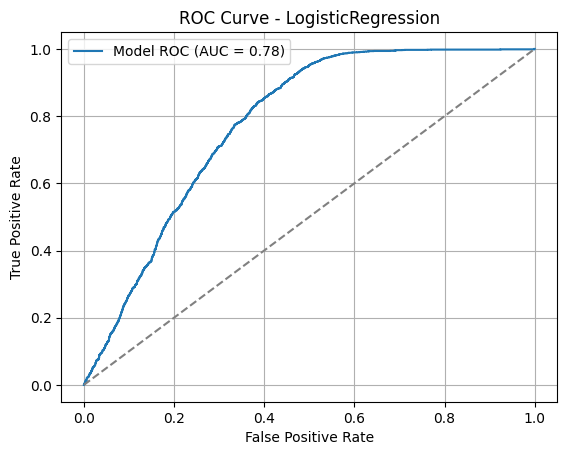

In [5]:
result_lr = train_model("LR", X_clf, y_clf)

y_test_lr = result_lr["y_test"]
y_prob_lr = result_lr["y_prob"]
accuracy_lr = result_lr["accuracy"]
auc_lr = result_lr["auc"]

fpr, tpr, _ = roc_curve(y_test_lr, y_prob_lr)


print("Accuracy:", accuracy_lr)
print("ROC AUC:", auc_lr)

plt.plot(fpr, tpr, label=f"Model ROC (AUC = {auc_lr:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - LogisticRegression")
plt.grid()
plt.legend()
plt.show()

## 🔍 Step 6: Train Random Forest Classifier (Score Prediction)

Accuracy: 0.7819169577027552
ROC AUC: 0.8696474908924934


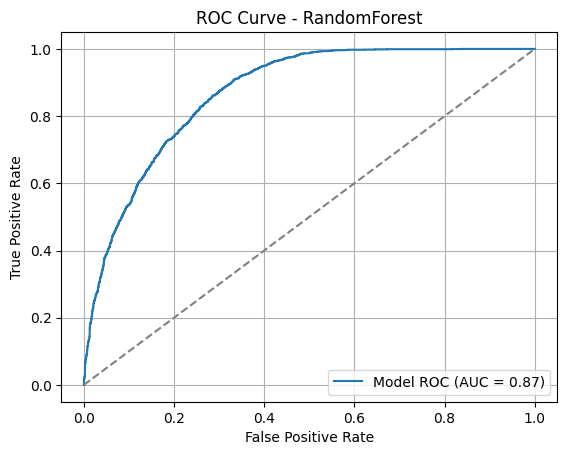

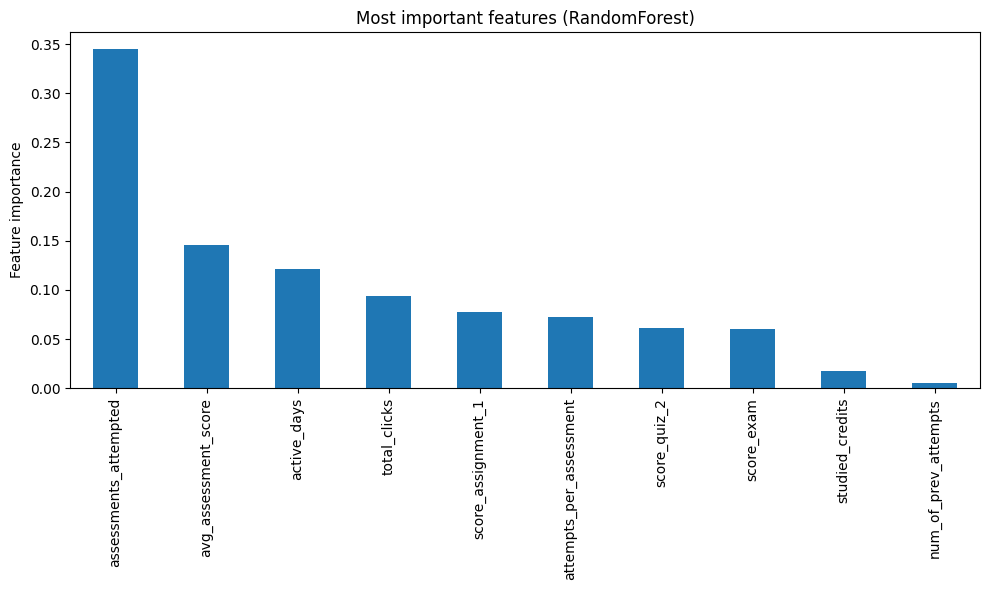

assessments_attempted      0.344723
avg_assessment_score       0.145660
active_days                0.121389
total_clicks               0.093651
score_assignment_1         0.077408
attempts_per_assessment    0.072499
score_quiz_2               0.061525
score_exam                 0.060367
studied_credits            0.017652
num_of_prev_attempts       0.005126
dtype: float64


In [6]:
result_rf = train_model("RF", X_clf, y_clf)
rf_model = result_rf["model"]

y_test_rf = result_rf["y_test"]
y_prob_rf = result_rf["y_prob"]
accuracy_rf = result_rf["accuracy"]
auc_rf = result_rf["auc"]

fpr, tpr, _ = roc_curve(y_test_rf, y_prob_rf)

print("Accuracy:", accuracy_rf)
print("ROC AUC:", auc_rf)

plt.plot(fpr, tpr, label=f"Model ROC (AUC = {auc_rf:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - RandomForest")
plt.grid()
plt.legend()
plt.show()

importances = pd.Series(
    rf_model.feature_importances_,
    index=X_clf.columns
).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
importances.head(15).plot(kind="bar")
plt.ylabel("Feature importance")
plt.title("Most important features (RandomForest)")
plt.tight_layout()
plt.savefig("rf_feature_importance.png", dpi=300)
plt.show()

print(importances.head(30))

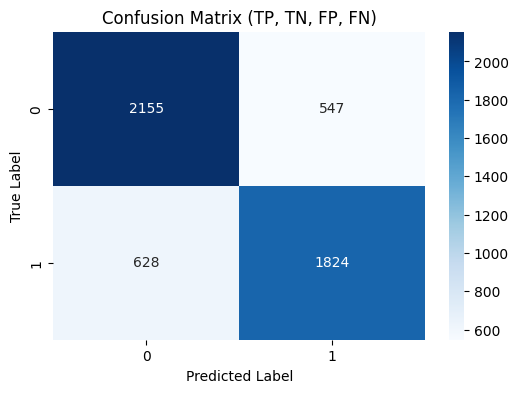

In [7]:
cm = confusion_matrix(y_test_rf, (y_prob_rf >= 0.6).astype(int))

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (TP, TN, FP, FN)")
plt.show()

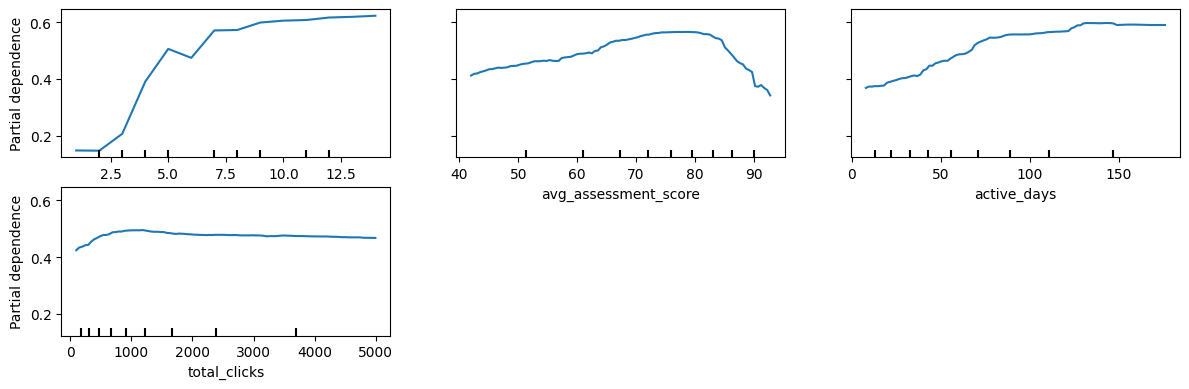

In [8]:
features_for_pdp = [
    "assessments_attempted",
    "avg_assessment_score",
    "active_days",
    "total_clicks"
]

fig, ax = plt.subplots(figsize=(12, 4))
PartialDependenceDisplay.from_estimator(
    rf_model,
    X_clf,
    features_for_pdp,
    ax=ax
)
plt.tight_layout()
plt.savefig("pdp_rf.png", dpi=300)
plt.show()

In [9]:
def explain_student(idx, model=rf_model, X=X_clf):
    print("="*65)
    print(f"📘 Student Analysis — Index: {idx}")
    print("="*65)

    # Select the student's feature row
    student_x = X.iloc[idx]

    # Model prediction and probability
    pred = model.predict(student_x.to_frame().T)[0]
    proba = model.predict_proba(student_x.to_frame().T)[0]

    print(f"\n🔮 Predicted class: {pred}   (0 = Fail, 1 = Pass)")
    print(f"🔢 Prediction probabilities — Fail: {proba[0]:.3f}, Pass: {proba[1]:.3f}")

    # Create a table: student value + feature importance
    analysis = pd.DataFrame({
        "feature": X.columns,
        "student_value": student_x.values,
        "importance": model.feature_importances_
    }).sort_values("importance", ascending=False)

    print("\n📊 Top features influencing this prediction:")
    print(analysis.head(10))

    # Automatic natural-language explanation
    print("\n🧠 Interpretation:")
    if pred == 0:
        print("➡️ The model predicts that this student is at high risk (Fail).")
    else:
        print("➡️ The model predicts that this student is likely to Pass.")

    print("\n🔍 Key contributing factors (compared to dataset averages):")

    # Generate explanation for top 5 features
    for _, row in analysis.head(5).iterrows():
        feat = row["feature"]
        val = row["student_value"]
        mean = X[feat].mean()          # <-- compute mean directly from X
        imp = row["importance"]

        status = "below" if val < mean else "above"

        print(f" - {feat}: {val:.2f} ({status} average {mean:.2f}), importance = {imp:.3f}")

    print("="*65)

In [10]:
all_preds = rf_model.predict(X_clf)
fail_students = np.where(all_preds == 0)[0]

print("Students predicted as FAIL:", fail_students)
print("Number of FAIL students:", len(fail_students))

explain_student(fail_students[0])
explain_student(all_preds[14])

Students predicted as FAIL: [   14    17    21 ... 25758 25760 25768]
Number of FAIL students: 10913
📘 Student Analysis — Index: 14

🔮 Predicted class: 0   (0 = Fail, 1 = Pass)
🔢 Prediction probabilities — Fail: 1.000, Pass: 0.000

📊 Top features influencing this prediction:
                   feature  student_value  importance
0    assessments_attempted       2.000000    0.344723
1     avg_assessment_score      67.000000    0.145660
3              active_days      11.000000    0.121389
2             total_clicks     171.000000    0.093651
6       score_assignment_1      67.122654    0.077408
9  attempts_per_assessment       0.307692    0.072499
7             score_quiz_2      66.798366    0.061525
8               score_exam      54.400641    0.060367
4          studied_credits      60.000000    0.017652
5     num_of_prev_attempts       0.000000    0.005126

🧠 Interpretation:
➡️ The model predicts that this student is at high risk (Fail).

🔍 Key contributing factors (compared to datase

## 📉 Step 4: Train Linear Regression (Score Prediction)

In [11]:
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

model_reg = LinearRegression()
model_reg.fit(X_train_r, y_train_r)

y_pred_r = model_reg.predict(X_test_r)

model_reg.coef_

list(X_reg.columns)

X_reg.iloc[14]

assessments_attempted        2
active_days                 11
total_clicks               171
studied_credits             60
score_assignment_1          67
score_quiz_2                66
score_exam                  54
attempts_per_assessment      0
Name: 14, dtype: int64

## 📉 Step 5: Evaluation Metrics for Linear Regression (Score Prediction)

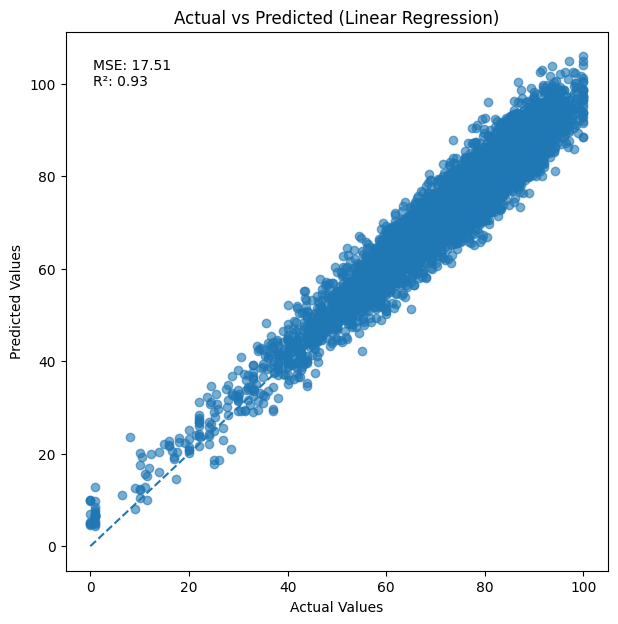

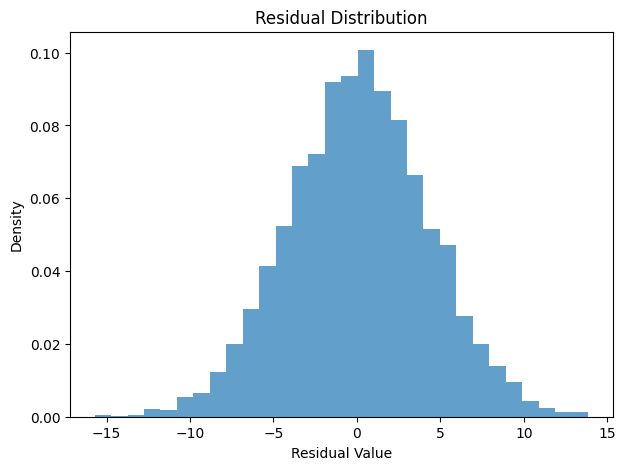

MSE: 17.509617812923544
R²: 0.9339121793666542


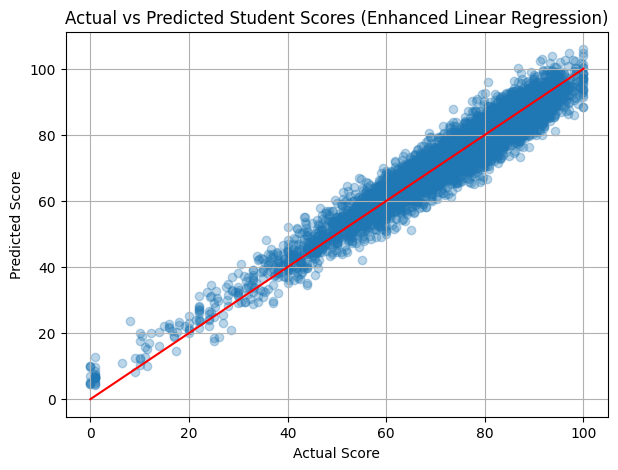


TOP INFLUENTIAL FEATURES:
                   feature  coefficient
4       score_assignment_1     0.628563
7  attempts_per_assessment     0.459223
5             score_quiz_2     0.305180
6               score_exam     0.126349
0    assessments_attempted     0.037210
2             total_clicks    -0.000381
3          studied_credits    -0.003560
1              active_days    -0.019482

NEGATIVE INFLUENTIAL FEATURES:
                   feature  coefficient
4       score_assignment_1     0.628563
7  attempts_per_assessment     0.459223
5             score_quiz_2     0.305180
6               score_exam     0.126349
0    assessments_attempted     0.037210
2             total_clicks    -0.000381
3          studied_credits    -0.003560
1              active_days    -0.019482


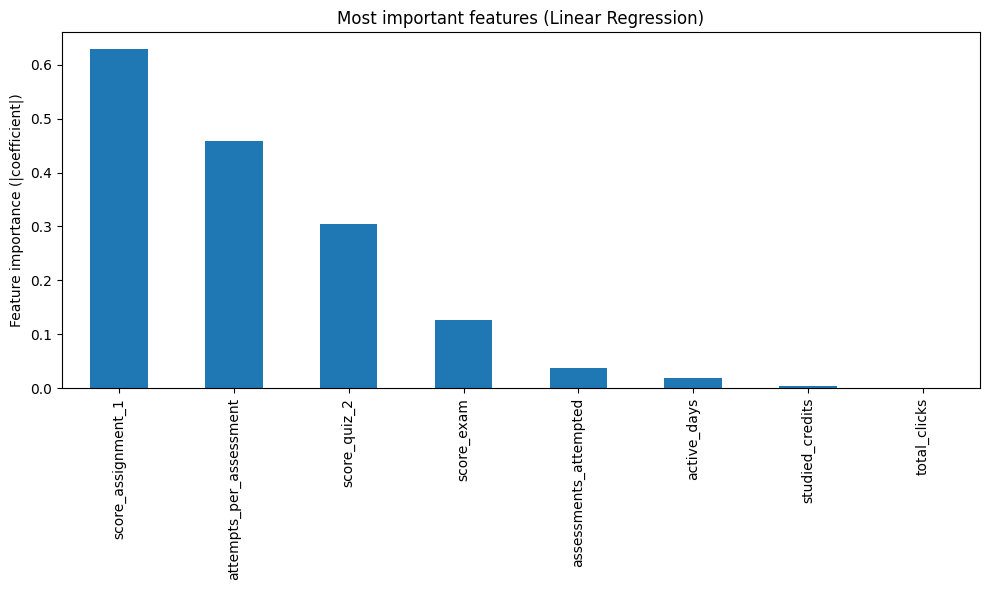

score_assignment_1         0.628563
attempts_per_assessment    0.459223
score_quiz_2               0.305180
score_exam                 0.126349
assessments_attempted      0.037210
active_days                0.019482
studied_credits            0.003560
total_clicks               0.000381
dtype: float64


In [12]:
# Metrics
mse = mean_squared_error(y_test_r, y_pred_r)
r2 = r2_score(y_test_r, y_pred_r)

plt.figure(figsize=(7, 7)) 
plt.scatter(y_test_r, y_pred_r, alpha=0.6) 
plt.plot([y_test_r.min(), y_test_r.max()], [y_test_r.min(), y_test_r.max()], linestyle='--') 
plt.xlabel("Actual Values") 
plt.ylabel("Predicted Values") 
plt.title("Actual vs Predicted (Linear Regression)") 
plt.text(0.05, 0.95, f"MSE: {mse:.2f}\nR²: {r2:.2f}", transform=plt.gca().transAxes, verticalalignment='top') 
plt.show()

residuals = y_test_r - y_pred_r

plt.figure(figsize=(7, 5))
plt.hist(residuals, bins=30, alpha=0.7, density=True)

plt.xlabel("Residual Value")
plt.ylabel("Density")
plt.title("Residual Distribution")

plt.show()

print("MSE:", mse)
print("R²:", r2)

plt.figure(figsize=(7,5))
plt.scatter(y_test_r, y_pred_r, alpha=0.3)
plt.plot([0,100], [0,100], color='red')
plt.xlabel("Actual Score")
plt.ylabel("Predicted Score")
plt.title("Actual vs Predicted Student Scores (Enhanced Linear Regression)")
plt.grid()
plt.show()

coeff_df = pd.DataFrame({
    "feature": X_reg.columns,
    "coefficient": model_reg.coef_
}).sort_values(by="coefficient", ascending=False)

print("\nTOP INFLUENTIAL FEATURES:")
print(coeff_df.head(10))
print("\nNEGATIVE INFLUENTIAL FEATURES:")
print(coeff_df.tail(10))

# 1. Get coefficients as a Series and sort by absolute value
lin_importance = pd.Series(
    np.abs(model_reg.coef_),   # take absolute values
    index=X_reg.columns
).sort_values(ascending=False)

# 2. (Optional) take top N features
top_n = 15
lin_top = lin_importance.head(top_n)

# 3. Plot
plt.figure(figsize=(10, 6))
lin_top.plot(kind="bar")
plt.ylabel("Feature importance (|coefficient|)")
plt.title("Most important features (Linear Regression)")
plt.tight_layout()
plt.show()

# If you also want to print numeric values:
print(lin_top)

In [13]:
import pandas as pd
import numpy as np

def explain_student_regression(idx, model, X, y=None, top_n=6):
    """
    Provides a human-readable explanation of a LinearRegression prediction
    for a student at a specific DataFrame index.

    Parameters:
    - idx : int
        Index of the student row in X
    - model : LinearRegression
        Trained regression model
    - X : pd.DataFrame
        Feature matrix used for training
    - y : pd.Series or None
        Actual target values (optional)
    - top_n : int
        Number of top positive and negative contributions to display
    """

    # --- Check index validity ---
    if idx < 0 or idx >= len(X):
        print(f"Index {idx} is out of range (valid: 0..{len(X)-1})")
        return

    # Model coefficients aligned with column names
    coefs = pd.Series(model.coef_, index=X.columns)

    # Feature values for this student
    x = X.iloc[idx]

    # Dataset means (for baseline comparison)
    means = X.mean()

    # Predicted score for this student
    pred = model.predict(x.values.reshape(1, -1))[0]

    # Actual target value if provided
    actual = y.iloc[idx] if y is not None else None

    # Baseline prediction for an "average" student
    baseline_pred = model.intercept_ + (coefs * means).sum()

    # Contribution of each feature relative to baseline:
    # contribution = coefficient * (student_value - dataset_mean)
    contributions = coefs * (x - means)

    # Build explanation table
    contrib_df = pd.DataFrame({
        "feature": X.columns,
        "student_value": x.values,
        "dataset_mean": means.values,
        "coefficient": coefs.values,
        "contribution": contributions.values
    })

    # Sort by total contribution
    contrib_sorted = contrib_df.sort_values("contribution", ascending=False)

    # Select the most positive and most negative contributors
    top_positive = contrib_sorted.head(top_n)
    top_negative = contrib_sorted.tail(top_n)

    # -------------------------------------------------------
    #          PRINT THE EXPLANATION REPORT
    # -------------------------------------------------------
    print("="*65)
    print(f"📘 Linear Regression — Student Analysis (index = {idx})")
    print("="*65)

    if actual is not None:
        print(f"🎯 Actual avg_assessment_score: {actual:.2f}")
    print(f"🔮 Predicted score:              {pred:.2f}")

    if actual is not None:
        print(f"📉 Error (actual - predicted):  {actual - pred:.2f}")

    print(f"🧷 Baseline (average student):   {baseline_pred:.2f}")
    print()

    # -------------------------
    # Top positive contributions
    # -------------------------
    print("🔝 Top positive contributions (push the score UP):")
    for _, row in top_positive.iterrows():
        feat = row["feature"]
        val = row["student_value"]
        mean = row["dataset_mean"]
        coef = row["coefficient"]
        contrib = row["contribution"]
        direction = (
            "above avg" if val > mean else
            "below avg" if val < mean else
            "≈ avg"
        )
        print(f" - {feat}: value={val:.2f} (mean={mean:.2f}, {direction}), "
              f"coef={coef:.3f}, contribution=+{contrib:.2f}")
    print()

    # -------------------------
    # Top negative contributions
    # -------------------------
    print("🔻 Top negative contributions (push the score DOWN):")
    for _, row in top_negative.sort_values("contribution").iterrows():
        feat = row["feature"]
        val = row["student_value"]
        mean = row["dataset_mean"]
        coef = row["coefficient"]
        contrib = row["contribution"]
        direction = (
            "above avg" if val > mean else
            "below avg" if val < mean else
            "≈ avg"
        )
        print(f" - {feat}: value={val:.2f} (mean={mean:.2f}, {direction}), "
              f"coef={coef:.3f}, contribution={contrib:.2f}")
    print()

    print("🧠 Interpretation:")
    print("Each feature contributes to the final score by shifting the prediction")
    print("relative to an 'average student'. Positive contributions raise the score;")
    print("negative contributions reduce it.")


In [14]:
explain_student_regression(11, model_reg, X_reg, y_reg)

📘 Linear Regression — Student Analysis (index = 11)
🎯 Actual avg_assessment_score: 78.60
🔮 Predicted score:              74.75
📉 Error (actual - predicted):  3.85
🧷 Baseline (average student):   72.76

🔝 Top positive contributions (push the score UP):
 - score_quiz_2: value=70.00 (mean=64.78, above avg), coef=0.305, contribution=+1.59
 - score_assignment_1: value=67.00 (mean=64.99, above avg), coef=0.629, contribution=+1.26
 - active_days: value=61.00 (mean=69.37, below avg), coef=-0.019, contribution=+0.16
 - total_clicks: value=1102.00 (mean=1524.04, below avg), coef=-0.000, contribution=+0.16
 - studied_credits: value=60.00 (mean=76.77, below avg), coef=-0.004, contribution=+0.06
 - attempts_per_assessment: value=0.00 (mean=0.03, below avg), coef=0.459, contribution=+-0.01

🔻 Top negative contributions (push the score DOWN):
 - score_exam: value=61.00 (mean=70.30, below avg), coef=0.126, contribution=-1.18
 - assessments_attempted: value=5.00 (mean=6.74, below avg), coef=0.037, cont

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


## ✅ Step 5: Reflect

In [15]:
# Based on model performance:
# - What features were most predictive?
# - Were there any surprises?
# - What additional data might improve your model?